# NLP and Sentiment Analysis based Trading Strategy

We use NLP to build a trading strategy


# Problem Statement

The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

# Getting Started- Loading the data and python packages


## Loading the python packages

As a first step we check if the additional packages needed are present. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies.

In [1]:
#import pkg_resources
#import pip
#installedPackages = {pkg.key for pkg in pkg_resources.working_set}
#required = {'nlp', 'yfinance', 'nltk', 'spacy', 'textblob', 'backtrader'}
#missing = required - installedPackages
#if missing:
#    !pip install nlp
#    !pip install yfinance
#    !pip install nltk==3.4
#    !pip install textblob==0.15.3
    #!pip install -U SpaCy==2.2.0
    #!python -m spacy download en_core_web_lg
#    !pip install backtrader==1.9.74.123    

Let us load the libraries

In [2]:
#NLP libraries
from textblob import TextBlob
#import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

############################################################################
# IMPORTANT 
# Run the command 
# python -m spacy download en_core_web_sm to download this
# https://spacy.io/models
############################################################################

# import en_core_web_lg
# nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
import textblob

# Keras package for the deep learning model for the sentiment prediction. 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding
#from tensorflow.keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt

#Additional Libraries 
import os.path
import sys


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucaslouvel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the stock price data

The stock price data is loaded in this step from Yahoo Finance in this step. The loaded data is saved in csv for further use.

In [4]:
import pandas as pd
import yfinance as yf

tickers = ['AAPL','MSFT','AMZN','GOOG','BA','WMT','JPM','TSLA','NFLX','ADBE']
start = '2010-01-01'
end = '2018-12-31'

if 1==1:
    df_ticker_return = pd.DataFrame()
    for ticker in tickers:    
        ticker_yf = yf.Ticker(ticker)
        if df_ticker_return.empty:
            df_ticker_return = ticker_yf.history(start = start, end = end)
            df_ticker_return['ticker']= ticker 
        else:
            data_temp = ticker_yf.history(start = start, end = end)
            data_temp['ticker']= ticker 
            df_ticker_return = df_ticker_return.append(data_temp)
    df_ticker_return.to_csv(r'Data\Step2.2_ReturnData.csv')
else:
    df_ticker_return = pd.read_csv(r'Data\Step2.2_ReturnData.csv')

Let us look at the details of the data

In [5]:
df_ticker_return.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-01-04 00:00:00-05:00,6.487649,6.520174,6.455732,6.505280,493729600,0.0,0.0,AAPL
2010-01-05 00:00:00-05:00,6.523215,6.553308,6.482178,6.516527,601904800,0.0,0.0,AAPL
2010-01-06 00:00:00-05:00,6.516526,6.542364,6.406185,6.412872,552160000,0.0,0.0,AAPL
2010-01-07 00:00:00-05:00,6.436581,6.444181,6.354509,6.401016,477131200,0.0,0.0,AAPL
2010-01-08 00:00:00-05:00,6.392507,6.444182,6.354815,6.443574,447610800,0.0,0.0,AAPL
2010-01-11 00:00:00-05:00,6.468498,6.474578,6.336271,6.386731,462229600,0.0,0.0,AAPL
2010-01-12 00:00:00-05:00,6.358766,6.376397,6.274567,6.314083,594459600,0.0,0.0,AAPL
2010-01-13 00:00:00-05:00,6.318643,6.411658,6.204046,6.403146,605892000,0.0,0.0,AAPL
2010-01-14 00:00:00-05:00,6.386734,6.397372,6.353600,6.366063,432894000,0.0,0.0,AAPL


The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2010 and the NAs in the data are dropped. Let us look at the news data now.

# Data Preparation

We divide the data preparation into couple of steps as follows:
* Loading and preprocessing the news data
* Preparing the combined data

## Loading and preprocessing News Data

The news data is downloaded from the News RSS feed and the file is downloaded in the json format and the json files for different dates are kept under a zipped folder. 

Let us see the content of the json file

In [6]:
import zipfile
import json  

z = zipfile.ZipFile("Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:]  

In [7]:
testFile

'Raw Headline Data/2011-05-11.json'

In [8]:
fileData[1]

34

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [9]:
#This function performs the json parsing given the 
from lxml import etree
from io import StringIO

def jsonParser(json_data): 

    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))

    assert len(main_tickers) == json_data['count']
    
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
        
    return main_tickers, final_headlines

In [10]:
jsonParser(json.loads(fileData))[1][3]

'Shares of Globecomm Systems (GCOM +10.3%) surge after news that the satellite-based communications company has hired JPMorgan as a financial advisor, a move that could lead to a sale of the company. A potential deal could value the company at $22/share, according to Deal Reporter.'

As we can see that using the json parser the news headlines are extracted from the complex html format. This format is good enough to be used for further analysis.

Now, we extract the ticker and the headlines from all the json files and put it in a dataframe. 

In [11]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
#        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
#        except:
#            pass  

In [12]:
data_df_news

[   ticker                                           headline        date
 0     DVA  Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...  2011-05-02
 1    CGNX  Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...  2011-05-02
 2    AEIS          Advanced Energy Industries (NASDAQ:AEIS):  2011-05-02
 3    LOCM                           Local.com (NASDAQ:LOCM):  2011-05-02
 4   CYDEQ                              CyberDefender (CYDE):  2011-05-02
 5    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02
 6     FRX  Forest Laboratories (FRX +5.3%) leads all S&P ...  2011-05-02
 7          A falling dollar brings handles not recently s...  2011-05-02
 8     CAG  Cereal and bakery products maker Ralcorp Holdi...  2011-05-02
 9    AMAT  Applied Materials (AMAT -2.3%) shares are down...  2011-05-02
 10         Crude oil retraces its plunge following the re...  2011-05-02
 11   NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02
 12   SPPI  Spectrum Pharmaceuticals (

Let us look at the content of the data

In [13]:
data_df_news=pd.concat(data_df_news)

In [14]:
data_df_news.head(50)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02
6,FRX,Forest Laboratories (FRX +5.3%) leads all S&P ...,2011-05-02
7,,A falling dollar brings handles not recently s...,2011-05-02
8,CAG,Cereal and bakery products maker Ralcorp Holdi...,2011-05-02
9,AMAT,Applied Materials (AMAT -2.3%) shares are down...,2011-05-02


As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return. Note that some tickers are missing - you may want to handle that.

## Preparing the combined data

In this step we extract the event return, which is the return that corresponds to
the event. We do this because at times the news is reported late and at other times it is
reported after market close. Having a slightly wider window ensures that we capture
the essence of the event. Event return in defined as follows:
$ R_{t-1} + R_t + R_{t+1} $

Where, $ R_{t-1} $, $ R_{t+1} $ are the return before and after the news data and $ R_{t} $ is the return on
the day of the news (i.e. time t)

In [15]:
# Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()

In [16]:
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] \
                             + df_ticker_return['ret_curr'].shift(-1) \
                             + df_ticker_return['ret_curr'].shift(1)

df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

Now we have all the data in place we will prepare a combined dataframe which will have the news headlines mapped to the date, event Return and stock ticker. This dataframe will be used for further analysis for sentiment analysis model and for building the trading strategy.

In [17]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [18]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [19]:
data_df.head(20)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285
74,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,20.120022
77,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,20.120022
86,MSFT,,2011-05-10,-0.019817,20.120022
109,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500
134,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.008073,12.912102
153,BA,"In ""a big win for Europe,"" the WTO partly over...",2011-05-18,0.003391,62.297932
162,MSFT,Accusing underwriters of digging out their lat...,2011-05-19,-0.001156,19.502409
164,MSFT,"If you bought LinkedIn (LNKD, now legging high...",2011-05-19,-0.001156,19.502409


Let us save the data in a csv file to be used later, so that the data processing step can be skipped everytime we are looking into analysis. 

In [20]:
data_df.dropna().to_csv(r'Step3_NewsAndReturnData.csv', sep='|', index=False)

## Loading the preprocessed data
#### Start from this step in case you dont want to run the previous preprocessing steps

In [21]:
data_df = pd.read_csv(r'Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [22]:
print(data_df.shape, data_df.ticker.unique().shape)

(2635, 5) (10,)


In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 10 unique stock tickers with total 2759 rows of data.

<a id='4'></a>
# 4 Evaluate Models for Sentiment Analysis

In this section we will go through following three different approaches of getting the sentiments for the news which we will use for building the trading strategy.

* Predefined model-TextBlob package
* Tuned Model-Classification algorithms
* Model based on financial lexicon

We will also explore the difference between different ways of performing the sentiment analysis. Let us go through the steps. 

## Our First Sentiment Model - TextBlob package

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [23]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [24]:
TextBlob(text1).sentiment.polarity

0.5

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

In [25]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

Let us analyse the scatterplot of the sentiments and the return.

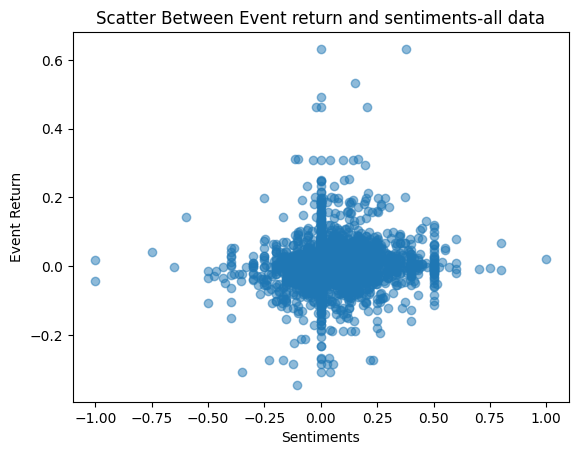

In [26]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [27]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.0744403104612275


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

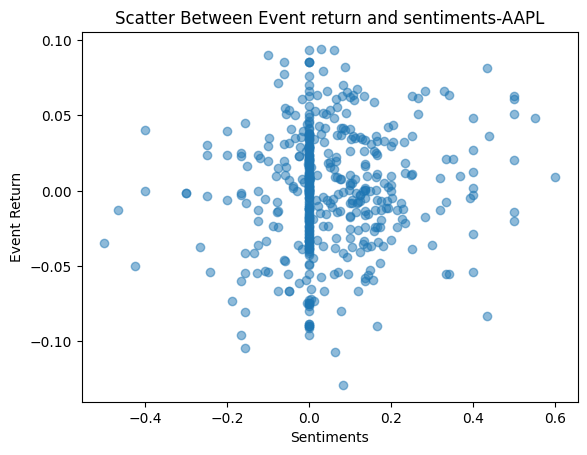

In [28]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

In [29]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. 

<a id='4.2'></a>
## 4.2 - Supervised Learning-Classification algorithms

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [30]:
sentiments_data = pd.read_csv(r'LabelledNewsData.csv',encoding = "ISO-8859-1")

In [31]:
sentiments_data.head(10)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0
5,1/6/2020 15:54,$MMM - 3M: The Fallen Dividend King Will Be Ba...,MMM,1
6,1/2/2020 14:35,$MMMcelebrates New Year with 7 month high clos...,MMM,1
7,1/2/2020 10:13,$MMM above 180 baby is going higher,MMM,1
8,12/28/2019 15:04,"$MMMhasn't really done much this year, but it ...",MMM,1
9,12/27/2019 0:28,3M $MMM Rating Increased to Neutral at JPMorga...,MMM,1


In [32]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


The data has headlines for the news across 30 different stocks, with total 9470 rows, and has sentiments labelled 0 and 1.

In order to run a supervised learning model, we first need to convert the news headlines into feature representation. 

In [33]:
# word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline']])

Now that we have prepared the independent variable we train the classification model in a similar manner as discussed in chapter 6. We first divide the data into training set and test set and futher run the key classification models. 

In [34]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensemble Models 
models.append(('RF', RandomForestClassifier()))

Running all the classification models

In [35]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:

    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.873285 (0.012427) 0.893951 0.870468
[[1035  169]
 [ 199 1438]]
KNN: 0.756221 (0.011859) 0.848243 0.763816
[[ 842  279]
 [ 392 1328]]
CART: 0.693017 (0.016711) 0.999698 0.689194
[[ 769  418]
 [ 465 1189]]
SVM: 0.830594 (0.009876) 0.862875 0.833861
[[ 955  193]
 [ 279 1414]]
NN: 0.900740 (0.007116) 0.998341 0.911651
[[1116  133]
 [ 118 1474]]
RF: 0.784134 (0.016164) 0.999698 0.790567
[[ 826  187]
 [ 408 1420]]


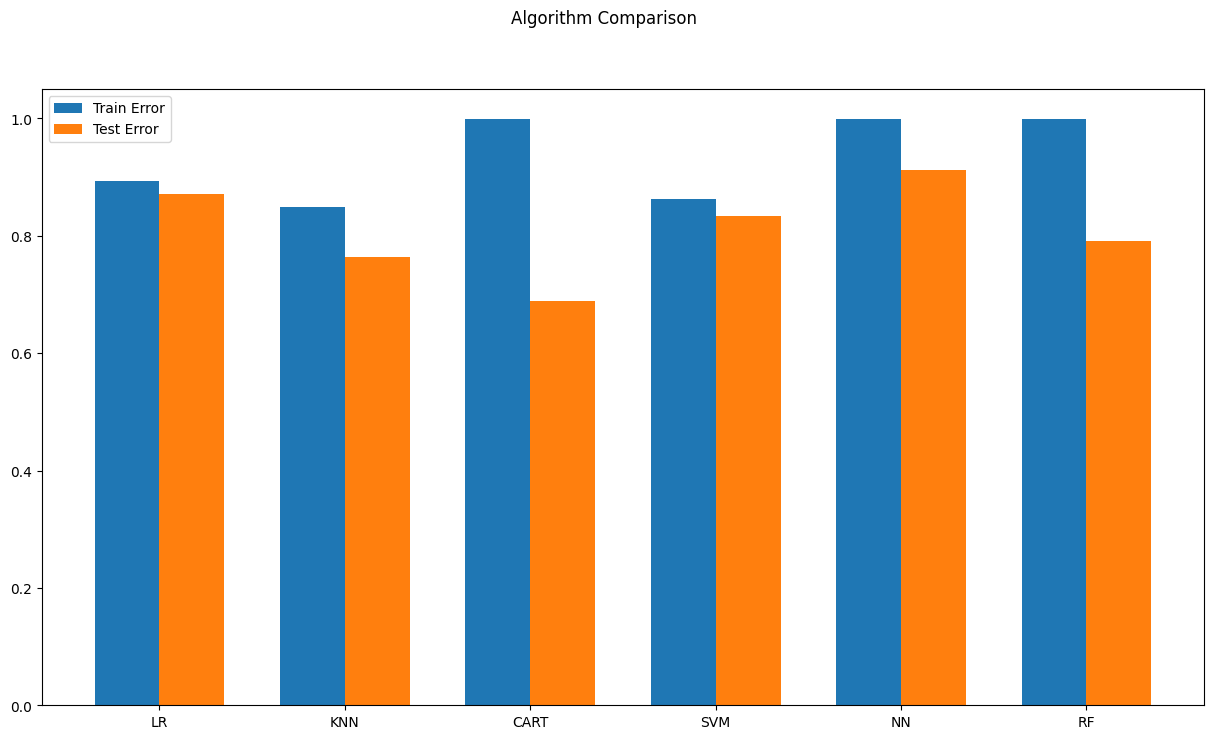

In [36]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As we can see the NN model is the best performer with the a training accuracy of 99% and test accuracy of 93%. The performance of Random forest, SVM and Logistic regression are good as well. CART and KNN don't perform as good as other models. CART has higher overfitting as well. 

In [37]:
# word-embedding of main headline data
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in data_df['headline']])

In [38]:
models

[('LR', LogisticRegression()),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('SVM', SVC()),
 ('NN', MLPClassifier()),
 ('RF', RandomForestClassifier())]

In [39]:
Y_NN = models[4][1].predict(all_vectors)

In [40]:
data_df['sentiment_NN'] = Y_NN 

In [41]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_NN'])
print(corrlation)

0.1043398907821369


In [42]:
data_df.head(1)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_NN
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,10.0595,0.2625,1


In [43]:
corr_models=[]
for i in range (6):
    col_name = 'sentiment_' + str(models[i][0])
    data_df[col_name] = models[i][1].predict(all_vectors)
    corr_models.append((models[i][0],data_df['eventRet'].corr(data_df[col_name])))
                    

In [44]:
corr_models

[('LR', 0.11218581667336924),
 ('KNN', -0.001276960345965045),
 ('CART', 0.005068748175036594),
 ('SVM', 0.09195335597930424),
 ('NN', 0.1043398907821369),
 ('RF', 0.017520092800807914)]

<a id='4.3'></a>
## 4.3 - Unsupervised - Model based on financial lexicon

Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.
VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package. 

In [45]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

Example of extracting sentiment score for a sentence:

In [46]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [47]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [48]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2635,)

In [49]:
data_df['sentiment_lex'] = vader_sentiments

In [50]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(corrlation)

0.16841719869124605


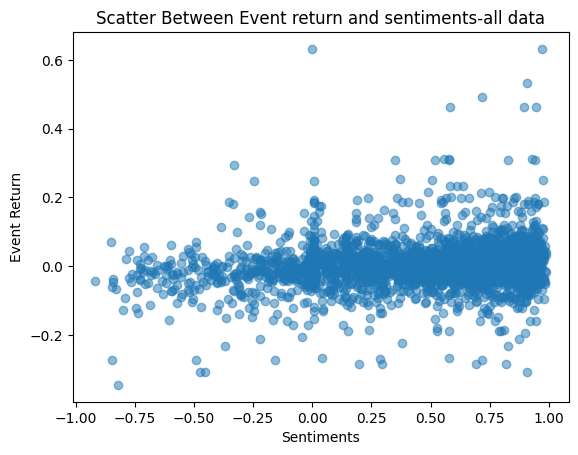

In [51]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

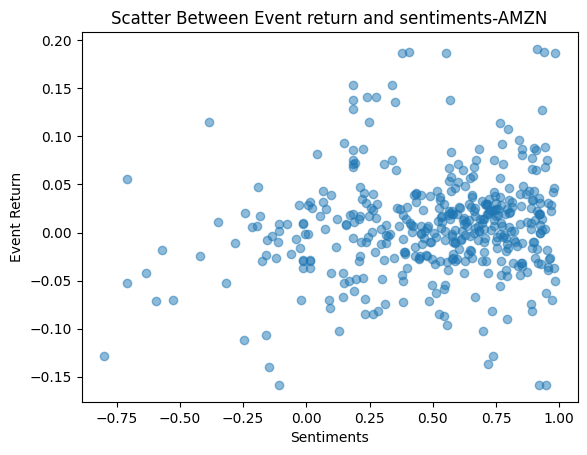

In [52]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We see a positive correlation between the event return and sentiments. We will look deeper into the comparison of different types of the sentiment analysis in the next section.

In [53]:
data_df.to_csv(r'Step4_DataWithSentimentsResults.csv', sep='|', index=False)

In [54]:
data_df.head(5)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_NN,sentiment_LR,sentiment_KNN,sentiment_CART,sentiment_SVM,sentiment_RF,sentiment_lex
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.262500,1,1,1,0,1,1,0.2115
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,-0.043750,1,1,1,1,1,1,0.8575
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,20.120022,0.166667,1,1,1,1,1,1,0.6971
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,20.120022,-0.030556,1,1,0,1,1,1,0.7751
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,0.000000,1,1,1,0,1,1,-0.0413


<a id='4.4'></a>
## 4.4 Exploratory Data Analysis and comparison

In [55]:
data_df = pd.read_csv(r'Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

Let us look at the sample headlines and the the sentiments from three different methodology, followed by the analysis using visualization. 

In [56]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob',
                                                       'sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,0.8575


Looking at one of the headlines, the sentiment from this sentence is positive. 

<Axes: title={'center': 'Correlation Matrix'}>

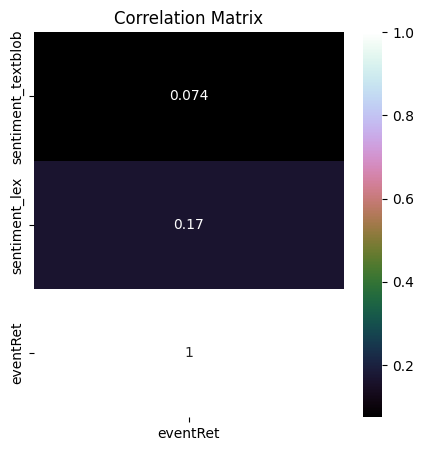

In [57]:
correlation = data_df[['sentiment_textblob','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

In [58]:
correlation

,sentiment_textblob,sentiment_lex,eventRet
sentiment_textblob,1.000000,0.272653,0.074440
sentiment_lex,0.272653,1.000000,0.168417
eventRet,0.074440,0.168417,1.000000


<Axes: title={'center': 'Correlation Matrix'}>

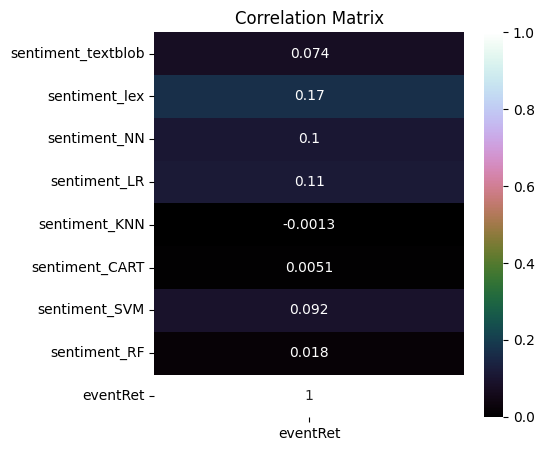

In [59]:
correlation = data_df[['sentiment_textblob','sentiment_lex','sentiment_NN','sentiment_LR','sentiment_KNN','sentiment_CART','sentiment_SVM','sentiment_RF','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

All the sentiments have positive relationship with the return which is intuitive and expected. 

In [60]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_lex])
        print(ticker, corr_lex, corr_textblob)
    else:
        continue

AMZN 0.1382960880385589 0.019829667384322007
NFLX 0.21874896527334026 0.09259214103465109
MSFT 0.034608765338054626 -0.025433542317982394
GOOG 0.19627025023938685 0.04424681185783118
BA 0.24221404630235768 0.2887781359530396
JPM 0.02522638764215014 -0.1605087318456942
TSLA 0.21366397208972784 0.11839963853288314
AAPL 0.21761097702759064 0.10841008185253631
WMT 0.10234951573335119 0.18667185584077006
ADBE 0.13032558907277844 0.03378531996388107


In [61]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob', 'corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(1)

,corr_textblob,corr_lex
ticker,,
AMZN,0.01983,0.138296


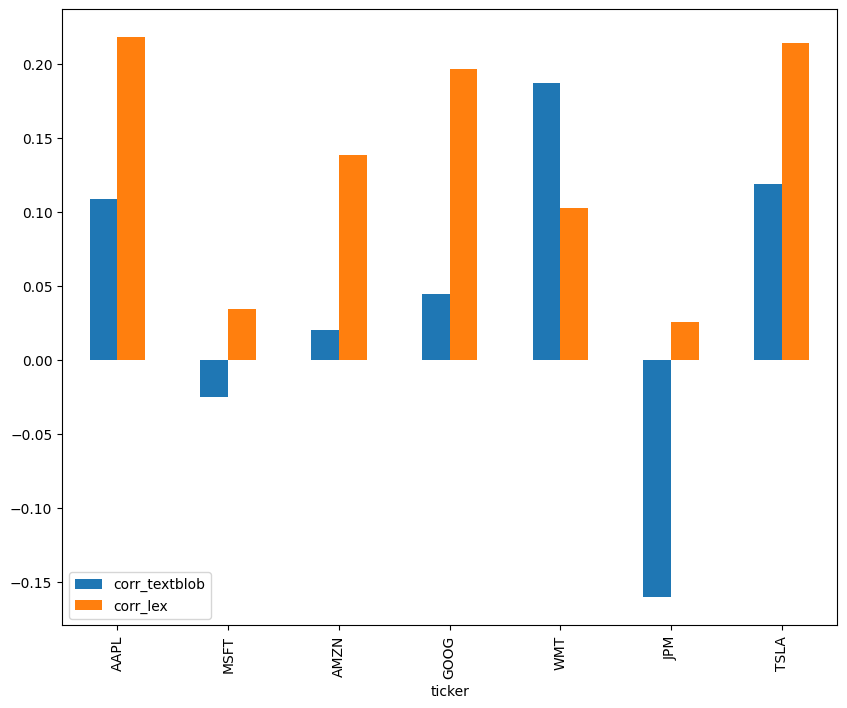

In [62]:
corr_df.to_csv("correlation.csv")     
tickers = ['AAPL','MSFT','AMZN','GOOG','WMT','JPM','TSLA']
corr_df.loc[tickers].plot.bar(figsize = (10,8))
plt.show()

Looking at the chart the corrlation from the lexicon methodology is highest across all the stock tickers, which corraborates the conclusion from the previous analysis.

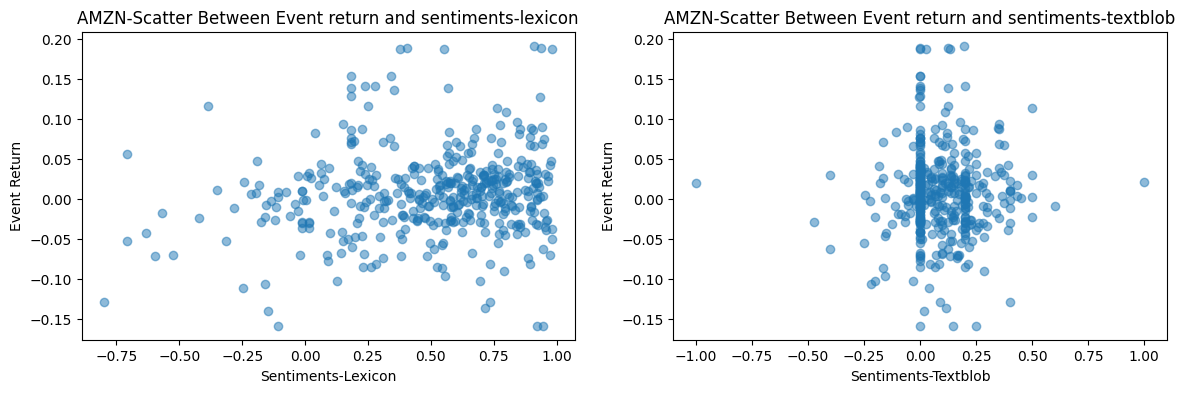

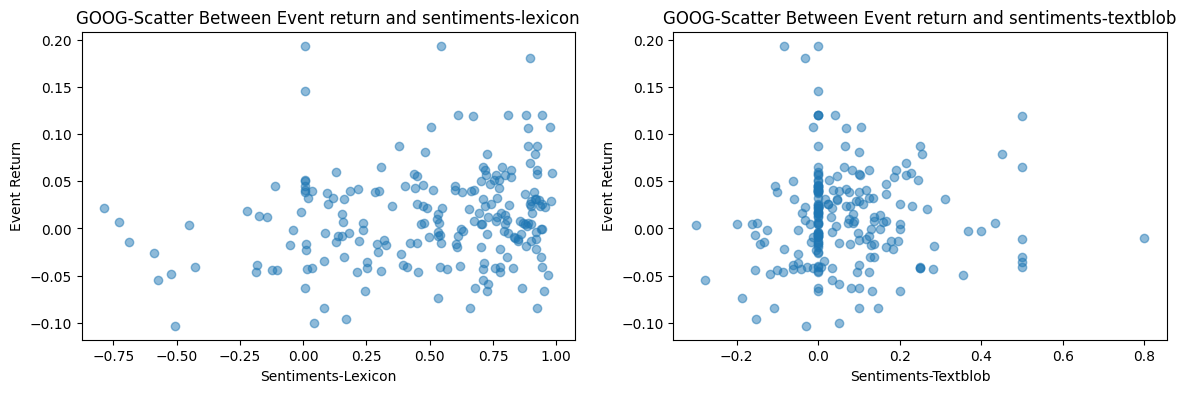

In [63]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()
    

The lexicon based sentiments on the left definitely shows a positive relationship between the sentiments and return. We use lexicon based sentiments for the trading strategy in the next step.

<a id='5'></a>
# 5. Model Evaluation- Building a Trading Strategy

The sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with positive score and selling the stocks with negative score. The sentiments can also be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy. 

In the trading strategy in this case study we buy and sell stock as per the current stock sentiments : 
* Buy a stock when the change in sentiment score (Current sentiment score - previous sentiment score) is greater than .5 and sell a stock when the change in sentiment score is less than -.5.
* Additionally, we check for 15 days moving average while buying and selling and buy or sell in a unit of 100. 

Obviusly, there can be many ways to create the trading strategy based in sentiments, by varying the threshold, or changing the number of units based on the initial cash available.

We use lexicon based sentiments for the trading strategy.


In [64]:
data_df_test=data_df
data_df_test.columns

Index(['ticker', 'headline', 'date', 'eventRet', 'Close', 'sentiment_textblob',
       'sentiment_NN', 'sentiment_LR', 'sentiment_KNN', 'sentiment_CART',
       'sentiment_SVM', 'sentiment_RF', 'sentiment_lex'],
      dtype='object')

Compute the 15 day moving average and the change in sentiment score

In [65]:
# Calculate the change in sentiment score
data_df_test = data_df.sort_values(['ticker', 'date'])
data_df_test['sentiment_change'] = data_df_test['sentiment_lex'] - data_df_test.groupby('ticker')['sentiment_lex'].shift()

In [66]:
df_ticker_return['15_day_ma'] = df_ticker_return.groupby('ticker')['Close'].rolling(window=15).mean().reset_index(0, drop=True)

In [67]:
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['date'], format='%Y-%m-%d')
df_ticker_return['date'] = df_ticker_return['date'].dt.strftime('%Y-%m-%d')

In [68]:
data_df_test = pd.merge(data_df_test, df_ticker_return[['date', 'ticker', '15_day_ma']], on=['date', 'ticker'], how='left')

We define the trading strategy as follow: 

We buy if the sentiment change is greater than 0.5 and the close price is greater than the 15 day moving average

We sell if the sentiment change is lower than -0.5 and the close price is lower than the 15 day moving average

Otherwise, we hold

In [69]:
def buy_sell_signal(row, threshold=0.5):
    if row['sentiment_change'] > threshold and row['Close'] > row['15_day_ma']:
        return 1  # Buy signal
    elif row['sentiment_change'] < -threshold and row['Close'] < row['15_day_ma']:
        return -1  # Sell signal
    else:
        return 0  # Hold signal

In [70]:
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1)
data_df_test.dropna(inplace=True)

In [71]:
def backtest_strategy(df, initial_investment=100000, position_size=100):
    df_sorted = df.sort_values(by='date', ignore_index=True)
    cash = initial_investment
    position_dict = {}  # dict to keep track of position for each ticker
    buy_price = 0
    sell_price = 0
    pnl = []

    for index, row in df_sorted.iterrows():
        ticker = row['ticker']
        signal = row['signal']

        # Initialize position for this ticker
        if ticker not in position_dict:
            position_dict[ticker] = 0

        # Buy signal
        if signal == 1 and cash >= row['Close'] * position_size:
            buy_price = row['Close']
            position = position_dict[ticker] + position_size
            position_dict[ticker] = position
            cash -= buy_price * position_size
            pnl.append((ticker, row['date'], position_size, buy_price, position, cash))
        # Sell signal
        elif signal == -1 and position_dict[ticker] != 0:
            sell_price = row['Close']
            position = position_dict[ticker] - position_size
            position_dict[ticker] = position
            cash += sell_price * position_size
            pnl.append((ticker, row['date'], -position_size, sell_price, position, cash))

    # Close any remaining positions
    for ticker, position in position_dict.items():
        if position > 0:
            cash += position * df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close']
            pnl.append((ticker, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['date'], -position, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close'],position, cash))
        elif position < 0:
            cash -= abs(position) * df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close']
            pnl.append((ticker, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['date'], -position, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close'],position, cash))

    # Add final cash balance to pnl
    #pnl.append(('CASH', df_sorted.iloc[-1]['date'], 0, 0,0, cash))

    return pnl


In [72]:
pnl_05 = backtest_strategy(data_df_test)

In [73]:
print('Total Profit : ',round(pnl_05[-1][-1]-100000,2))

Total Profit :  320645.2


If we start from 1M instead of 100 000$

In [74]:
pnl_05_1M = backtest_strategy(data_df_test, initial_investment=1000000)
print('Total Profit for 1M initial investment: ',round(pnl_05_1M[-1][-1]-1000000,2))

Total Profit for 1M initial investment:  410320.44


We will focus on 100 000$ in initial investment

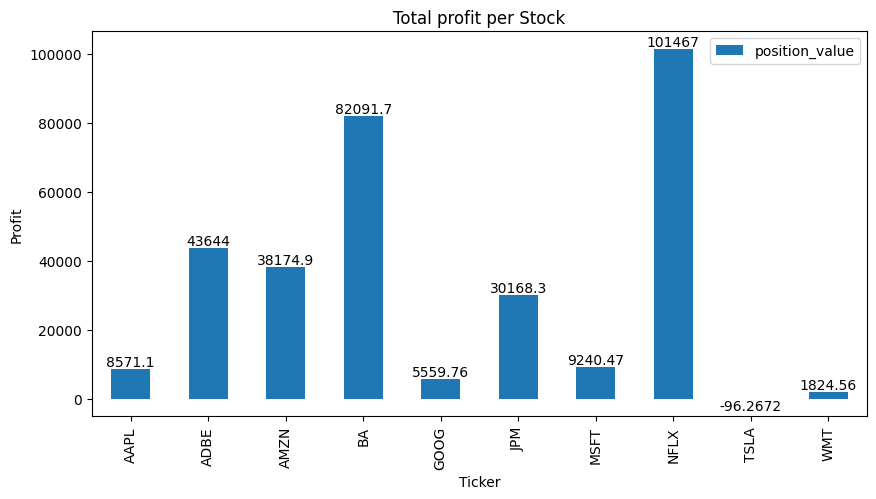

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(pnl_05, columns=['ticker', 'date', 'position_size', 'price', 'position', 'cash'])

df['position_value'] = -df['position_size'] * df['price']

df_grouped = df.groupby('ticker').agg({'position_value': 'sum'})


ax = df_grouped.plot(kind='bar', figsize=(10, 5))
ax.set_xlabel('Ticker')
ax.set_ylabel('Profit')
ax.set_title('Total profit per Stock')
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.show()


We want to display the values of the position over the period

In [76]:
import pandas as pd

operations_df = pd.DataFrame(pnl_05, columns=['ticker', 'date', 'position_size', 'price','position','cash'])

operations_df['date'] = pd.to_datetime(operations_df['date'])

operations_df['date'] = pd.to_datetime(operations_df['date'], format='%Y-%m-%d')
operations_df['date'] = operations_df['date'].dt.strftime('%Y-%m-%d')


merged_df = pd.merge(operations_df, df_ticker_return, how='left', left_on=['ticker', 'date'], right_on=['ticker', 'date'])

col_names = {col: col + '_2' if col in ['position', 'Close'] else col for col in merged_df.columns}


pivoted_df = merged_df.pivot_table(values=['position','Close'], index='date', columns='ticker')
pivoted_df = pivoted_df.ffill().fillna(0) # carry forward values until a change, then replace missing values with 0


pivoted_df = pivoted_df.reset_index()
pivoted_df.columns = [col_names.get(col, col) for col in pivoted_df.columns]

We create a dataframe with all the dates, close price and position of each stock 

In [77]:
detail_pnl=pd.DataFrame(pivoted_df[('date','')])
for i in ['AAPL','ADBE','AMZN','BA','GOOG','JPM','MSFT','NFLX','TSLA','WMT']:
    detail_pnl[i]=pivoted_df[('Close',i)]*pivoted_df[('position',i)]
detail_pnl['Total Position Value']= detail_pnl.sum(axis=1)

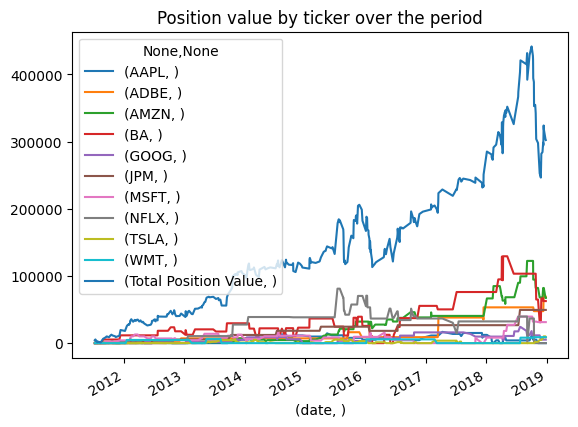

In [78]:
detail_pnl[('date', '')] = pd.to_datetime(detail_pnl[('date', '')], format='%Y/%m/%d')
x_values = detail_pnl[('date', '')].dt.year

detail_pnl.plot(x=('date', ''), y=detail_pnl.columns[1:], kind='line')

plt.title('Position value by ticker over the period')

plt.show()


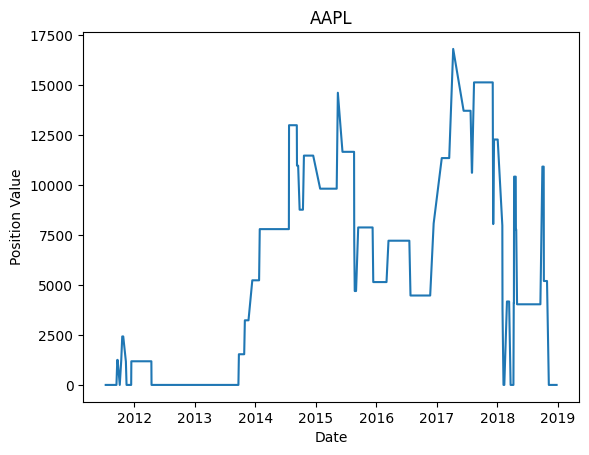

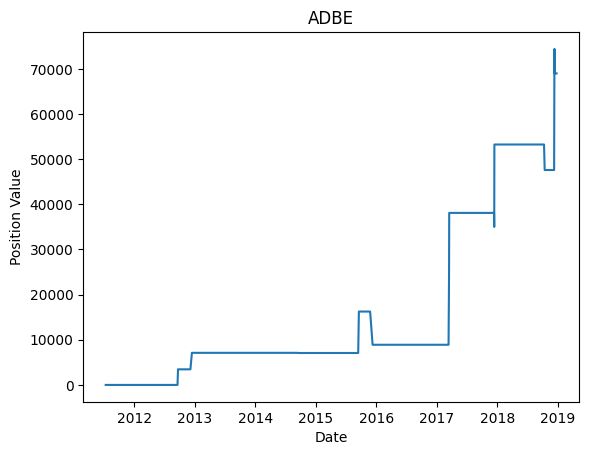

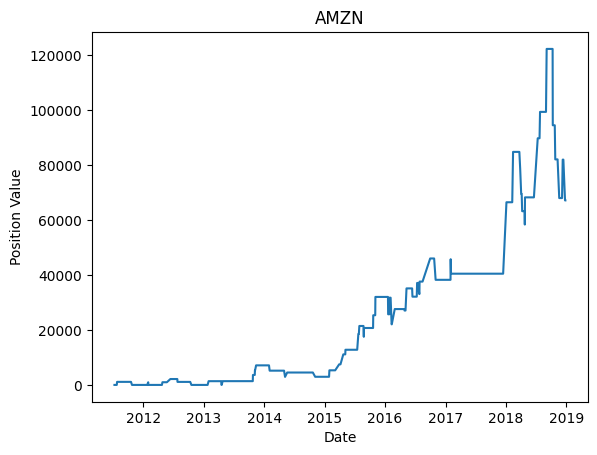

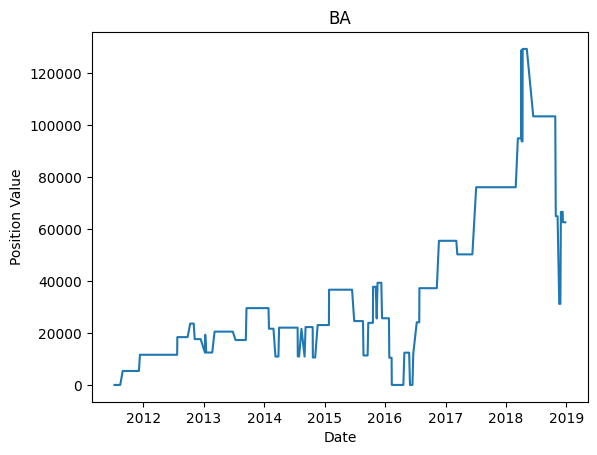

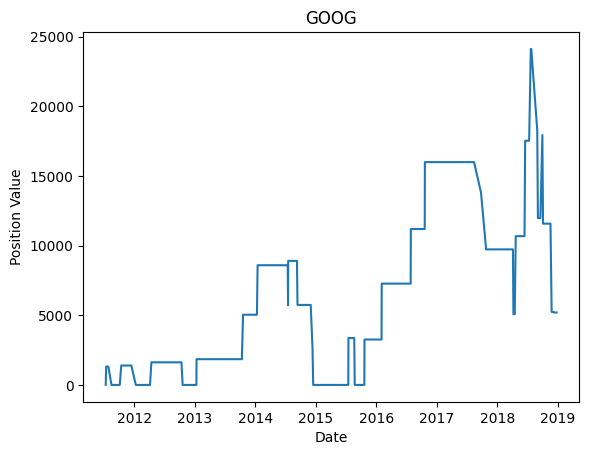

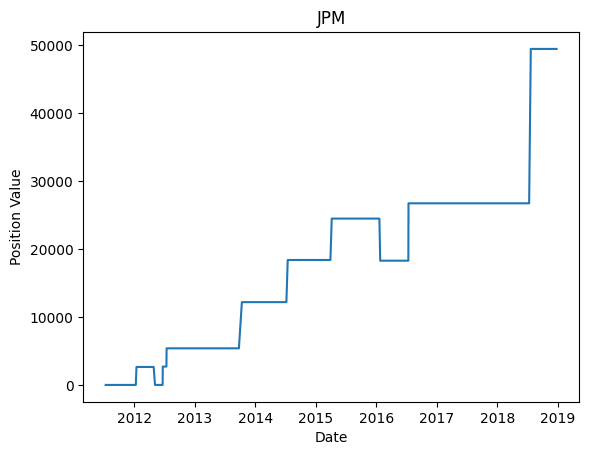

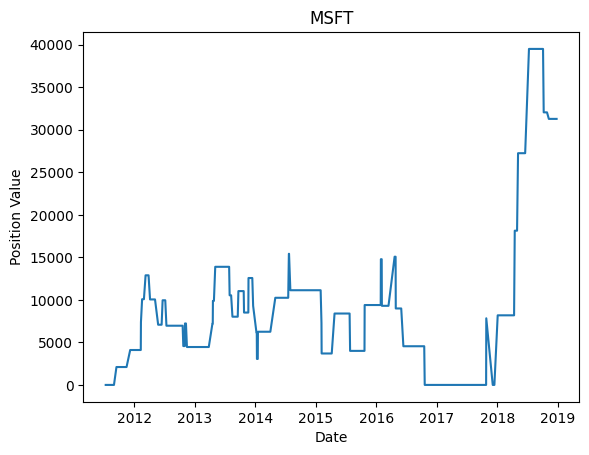

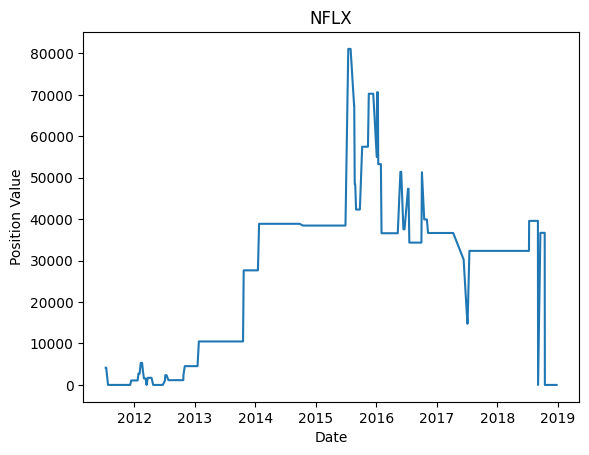

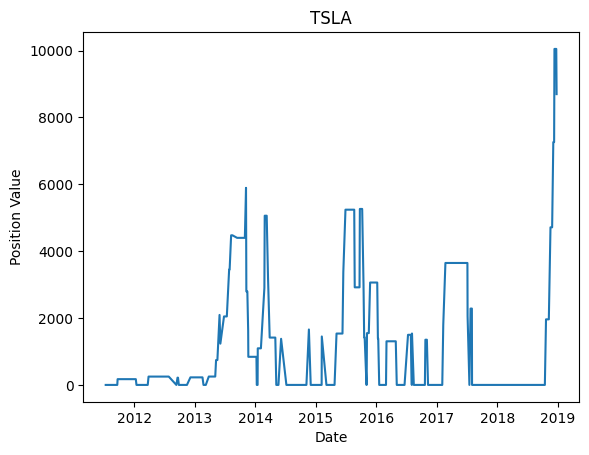

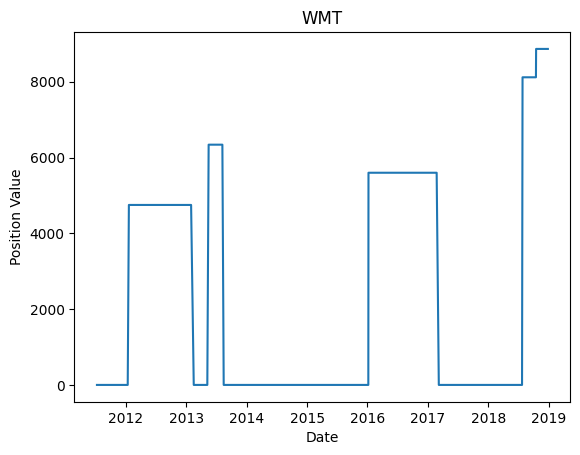

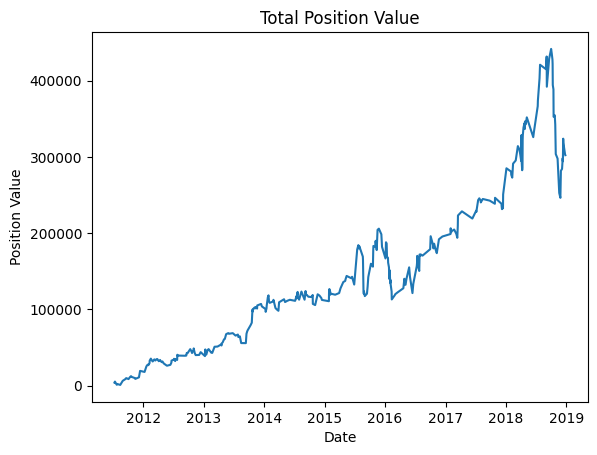

In [79]:
for column in detail_pnl.columns[1:]:
    plt.plot(detail_pnl[('date', '')], detail_pnl[column])
    plt.title(column[0])
    plt.xlabel('Date')
    plt.ylabel('Position Value')
    plt.show()

### Improve the strategy

We look for the best threshold for the model

In [80]:
profits=[]
for t in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=t)
    data_df_test.dropna(inplace=True)
    
    pnl = backtest_strategy(data_df_test)
    profits.append((t,round(pnl[-1][-1]-100000,2)))
    
    
print(profits)

[(0.1, 542751.05), (0.2, 506990.47), (0.3, 464171.9), (0.4, 382427.83), (0.5, 320645.2), (0.6, 283661.8), (0.7, 275623.88), (0.8, 229397.67), (0.9, 221751.95)]


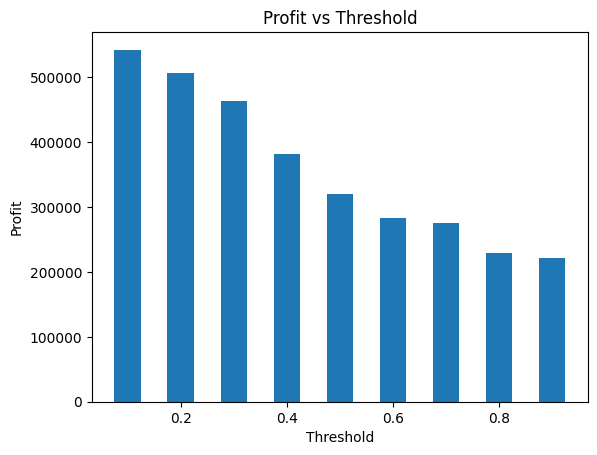

In [81]:
thresholds, profit = zip(*[(t, p) for t, p in profits])
plt.bar(thresholds, profit,width=0.05)
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit vs Threshold')
plt.show()

We compute the strategy with a threshold of 0.1

In [82]:
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.1)
data_df_test.dropna(inplace=True)
    
pnl_01 = backtest_strategy(data_df_test)
print('Total Profit : ',round(pnl_01[-1][-1]-100000,2))

Total Profit :  542751.05


In [83]:
#for 1M initial investment
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.1)
data_df_test.dropna(inplace=True)
    
pnl_01_1M = backtest_strategy(data_df_test,initial_investment=1000000)
print('Total Profit for 1M initial investment: ',round(pnl_01_1M[-1][-1]-1000000,2))

Total Profit for 1M initial investment:  1131222.68


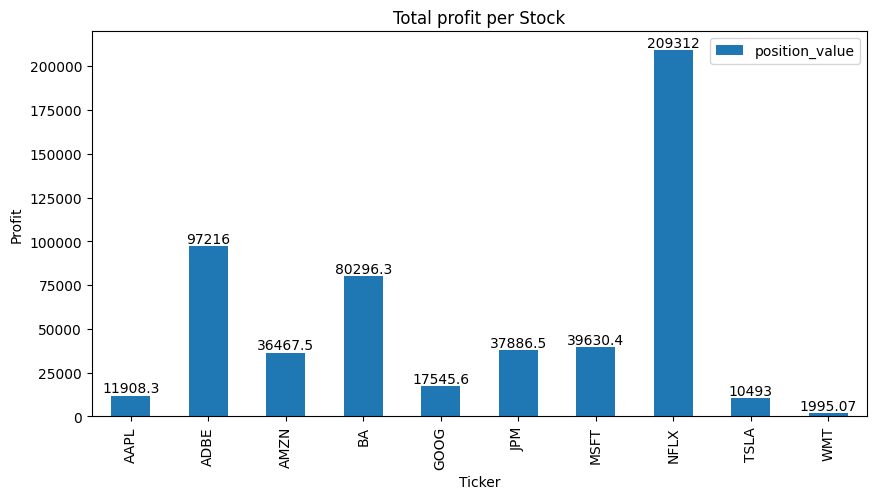

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(pnl_01, columns=['ticker', 'date', 'position_size', 'price', 'position', 'cash'])
df['position_value'] = -df['position_size'] * df['price']

df_grouped = df.groupby('ticker').agg({'position_value': 'sum'})

ax = df_grouped.plot(kind='bar', figsize=(10, 5))
ax.set_xlabel('Ticker')
ax.set_ylabel('Profit')
ax.set_title('Total profit per Stock')
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.show()

Then, we look for the best position size

In [85]:
#for a 0.5 threshold
profits_p=[]
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.5)
data_df_test.dropna(inplace=True)

for s in [50,100,200,300,400, 500, 600, 700, 800, 900, 1000]:
    pnl = backtest_strategy(data_df_test,position_size=s)
    profits_p.append((s,round(pnl[-1][-1]-100000,2)))
print(profits_p)

[(50, 202443.29), (100, 320645.2), (200, 434431.2), (300, 474877.87), (400, 570055.92), (500, 550059.07), (600, 625445.17), (700, 693932.17), (800, 735647.03), (900, 780322.08), (1000, 875648.0)]


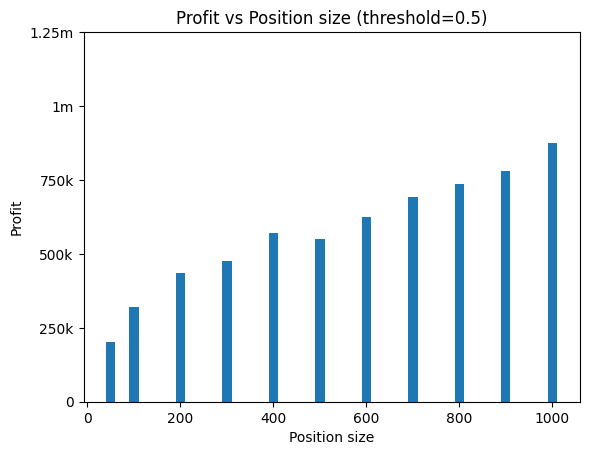

In [86]:
position_size, profit_p = zip(*[(s, p) for s, p in profits_p])
plt.bar(position_size, profit_p,width = 20)
plt.xlabel('Position size')
plt.ylabel('Profit')
plt.yticks([0, 250000, 500000, 750000, 1000000, 1250000], ['0', '250k', '500k', '750k', '1m', '1.25m'])
plt.title('Profit vs Position size (threshold=0.5)')
plt.show()

In [87]:
#for a 0.1 threshold
profits_p=[]
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.1)
data_df_test.dropna(inplace=True)

for s in [50,100,200,300,400, 500, 600, 700, 800, 900, 1000]:
    pnl = backtest_strategy(data_df_test,position_size=s)
    profits_p.append((s,round(pnl[-1][-1]-100000,2)))
print(profits_p)

[(50, 399057.09), (100, 542751.05), (200, 706825.64), (300, 706331.92), (400, 729434.85), (500, 979682.79), (600, 919526.86), (700, 923639.88), (800, 1116665.28), (900, 1216420.55), (1000, 909288.13)]


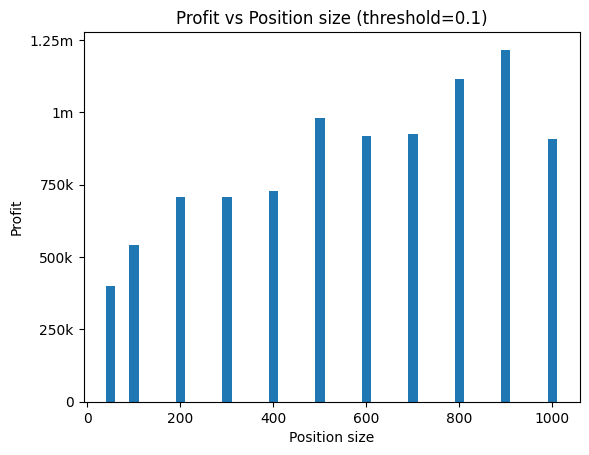

In [88]:
position_size, profit_p = zip(*[(s, p) for s, p in profits_p])
plt.bar(position_size, profit_p,width = 20)
plt.xlabel('Position size')
plt.ylabel('Profit')
plt.yticks([0, 250000, 500000, 750000, 1000000, 1250000], ['0', '250k', '500k', '750k', '1m', '1.25m'])
plt.title('Profit vs Position size (threshold=0.1)')
plt.show()

In [89]:
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.1)
data_df_test.dropna(inplace=True)
    
pnl_01_900 = backtest_strategy(data_df_test,position_size=900)
print('Total Profit : ',round(pnl_01_900[-1][-1]-100000,2))

Total Profit :  1216420.55


In [90]:
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.1)
data_df_test.dropna(inplace=True)
    
pnl_01_900_1M = backtest_strategy(data_df_test,position_size=900, initial_investment=1000000)
print('Total Profit for 1M initial investment: ',round(pnl_01_900_1M[-1][-1]-1000000,2))

Total Profit for 1M initial investment:  5037035.46


### Transaction cost

We define the transaction cost at 5$

In [91]:
def backtest_strategy_tc(df, initial_investment=100000, position_size=100, transaction_fee=5):
    df_sorted = df.sort_values(by='date', ignore_index=True)
    cash = initial_investment
    position_dict = {}  # dict to keep track of position for each ticker
    buy_price = 0
    sell_price = 0
    pnl = []

    for index, row in df_sorted.iterrows():
        ticker = row['ticker']
        signal = row['signal']

        # Initialize position for this ticker
        if ticker not in position_dict:
            position_dict[ticker] = 0

        # Buy signal
        if signal == 1 and cash >= (row['Close'] * position_size) + transaction_fee:
            buy_price = row['Close']
            position = position_dict[ticker] + position_size
            position_dict[ticker] = position
            cash -= (buy_price * position_size) + transaction_fee
            pnl.append((ticker, row['date'], position_size, buy_price, position, cash))
        # Sell signal
        elif signal == -1 and position_dict[ticker] != 0:
            sell_price = row['Close']
            position = position_dict[ticker] - position_size
            position_dict[ticker] = position
            cash += (sell_price * position_size) - transaction_fee
            pnl.append((ticker, row['date'], -position_size, sell_price, position, cash))

    # Close any remaining positions
    for ticker, position in position_dict.items():
        if position > 0:
            cash += (position * df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close']) - transaction_fee
            pnl.append((ticker, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['date'], -position, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close'],position, cash))
        elif position < 0:
            cash -= (position * df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close']) + transaction_fee
            pnl.append((ticker, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['date'], -position, df_sorted[df_sorted['ticker'] == ticker].iloc[-1]['Close'],position, cash))
    
    return pnl


First, let's see the impact of the transaction cost on the basic strategy threshold = 0.5, position size = 100

In [92]:
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.5)
data_df_test.dropna(inplace=True)

pnl_tc_05 = backtest_strategy_tc(data_df_test)
print('Total profit with transaction cost: ',round(pnl_tc_05[-1][-1]-100000,2))

Total profit with transaction cost:  316486.94


In [93]:
total_tc_05 = pnl_05[-1][-1]-pnl_tc_05[-1][-1]
print('Impact of Transaction cost: ', round(total_tc_05,2))

Impact of Transaction cost:  4158.26


Finally, the impact of the transaction cost on the improved strategy with threshold = 0.1, position size = 900

In [94]:
data_df_test['signal'] = data_df_test.apply(buy_sell_signal, axis=1,threshold=0.1)
data_df_test.dropna(inplace=True)

pnl_tc_01 = backtest_strategy_tc(data_df_test, position_size=900)
print('Total profit with transaction cost: ',round(pnl_tc_01[-1][-1]-100000,2))

Total profit with transaction cost:  963677.31


In [95]:
pnl_improved = backtest_strategy(data_df_test, position_size=900)

total_tc_01 = pnl_improved[-1][-1]-pnl_tc_01[-1][-1]
print('Impact of Transaction cost: ', round(total_tc_01,2))

Impact of Transaction cost:  252743.24


The transaction have a significant impact on the improved strategy, due to the large position size the cash is used very quickly to buy positions. At the very beginning, because of the transaction cost there is not enough cash to buy the same position as we are slightly below the treshold. Then, by missing some opportunities due to the large size of each trade the strategy has less cash over the year and miss more and more opportunities, resulting in a consequent impact. 